# Clustering

Clustering is one of the primary methods of machine learning known as unsupervised learning.  Meaning we try to get a machine to find patterns in the data without giving labels or desired output.

## Load packages and data
We already checked the data that we will use yesterday so we are not going to reuse that.  We will however this time create our analysis dataset, a single table that we can use to run our analysis models on.

In [2]:
# Load our helpers
source("../using.R")
source("../percent.R")
source("../sift.R")
# Load our packages
using( tidyverse, magrittr, RMySQL, DBI, dbplyr, stringr, lubridate
     , forcats, ggplot2)

# connect to the database
mimic.db <- dbConnect( RMySQL::MySQL(), host="mysql", port=3306
                     , user="jovyan", password="jovyan", dbname="mimic2"
                     )
# Expose all the tables.
for(tb in dbListTables(mimic.db)) 
    assign(tb, tbl(mimic.db, tb))

Loading required package: tidyverse
Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: magrittr
Loading required package: RMySQL
Loading required package: DBI
Loading required package: dbplyr
Loading required package: stringr
Loading required package: lubridate
Loading required package: forcats


## Creating an analysis dataset

We are first going to cluster patients by symptoms

### ICD-9

In [3]:
ls() %>% sift('icd')

glimpse(icd9)

[1] "icd9"

Observations: 25
Variables: 5
$ subject_id  <int> 56, 56, 56, 56, 56, 56, 56, 56, 37, 37, 37, 37, 37, 37,...
$ hadm_id     <int> 28766, 28766, 28766, 28766, 28766, 28766, 28766, 28766,...
$ sequence    <int> 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2...
$ code        <chr> "198.3", "162.8", "531.40", "276.1", "428.0", "780.39",...
$ description <chr> "SECONDARY MALIGNANT NEOPLASM OF BRAIN AND SPINAL C", "...


In [4]:
count(icd9)
count(icd9, sequence)

# Source:   lazy query [?? x 1]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
      n
  <dbl>
1 53486

# Source:   lazy query [?? x 2]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
   sequence     n
      <int> <dbl>
 1        1  5061
 2        2  5050
 3        3  5025
 4        4  4958
 5        5  4840
 6        6  4640
 7        7  4393
 8        8  4081
 9        9  3672
10       10  1838
# ... with more rows

In [5]:
patient.icd9 <- count(icd9, subject_id, code, description) %>% ungroup
count(patient.icd9)

count(ungroup(count(icd9, subject_id, code)))


# Source:   lazy query [?? x 1]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
     nn
  <dbl>
1 51327

# Source:   lazy query [?? x 1]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
     nn
  <dbl>
1 49093

This is not much of a reduction.

In [6]:
source("../get_duplicated.R")

icd9 %>% get_duplicated(code, description)
icd9 %>% get_duplicated(code, description) %>% class
icd9 %>% get_duplicated(code, description) %>% count


# Source:   lazy query [?? x 2]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
     code                                        description
    <chr>                                              <chr>
 1  007.4                                  CRYPTOSPORIDIOSIS
 2  007.4       "OTH PROTOZOAL INT DISEAS                \r"
 3 008.45  INTESTINAL INFECTION DUE TO CLOSTRIDIUM DIFFICILE
 4 008.45       "INTESTIN INF CLOSTRIOIUM                \r"
 5 008.69             ENTERITIS DUE TO OTHER VIRAL ENTERITIS
 6 008.69       "ENTERITIS D/T OTH VIRUS                 \r"
 7  008.8 INTESTINAL INFECTION DUE TO OTHER ORGANISM NOT ELS
 8  008.8       "VIRAL ENTERITIS NOS                     \r"
 9 032.85       "CUTANEOUS DIPHTHERIA                    \r"
10 032.85                               CUTANEOUS DIPHTHERIA
# ... with more rows

[1] "tbl_dbi"  "tbl_sql"  "tbl_lazy" "tbl"

# Source:   lazy query [?? x 1]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
      n
  <dbl>
1  2290

In [7]:
icd9 %>% collect %>% 
    filter(str_sub(code,1,4) %in% as.character(780:799)) %>% 
    count(code)

code,n


In [8]:
using(icd)
icd9 %>% collect %$% as.icd9cm(code) %>% icd_is_valid %>% sum

Loading required package: icd
Welcome to the "icd" package for finding comorbidities and interpretation of ICD-9 and ICD-10 codes. Suggestions and contributions are welcome at https://github.com/jackwasey/icd .

See the vignettes and help for examples.

Please cite this package if you find it useful in your published work.
citation(package = "icd")



[1] 53486

In [9]:
icd9 %>% select(code) %>% distinct() %>% count

# Source:   lazy query [?? x 1]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
      n
  <dbl>
1  2719

In [10]:
icd.expl.tbl <- icd9 %>% 
    select(code) %>% distinct%>% collect %$%
    icd_explain_table(as.icd9cm(code)) %>%
    tbl_df %>%
    mutate(code = icd_short_to_decimal(code))
count(icd.expl.tbl)
icd.expl.tbl %>% head

n
2719


code,short_desc,long_desc,three_digit,major,sub_chapter,chapter,is_major,valid_icd9,valid_icd10
198.3,Sec mal neo brain/spine,Secondary malignant neoplasm of brain and spinal cord,198,Secondary malignant neoplasm of other specified sites,Malignant Neoplasm Of Other And Unspecified Sites,Neoplasms,FALSE,TRUE,FALSE
162.8,Mal neo bronch/lung NEC,Malignant neoplasm of other parts of bronchus or lung,162,"Malignant neoplasm of trachea, bronchus, and lung",Malignant Neoplasm Of Respiratory And Intrathoracic Organs,Neoplasms,FALSE,TRUE,FALSE
531.40,Chr stomach ulc w hem,"Chronic or unspecified gastric ulcer with hemorrhage, without mention of obstruction",531,Gastric ulcer,"Diseases Of Esophagus, Stomach, And Duodenum",Diseases Of The Digestive System,FALSE,TRUE,FALSE
276.1,Hyposmolality,Hyposmolality and/or hyponatremia,276,"Disorders of fluid, electrolyte, and acid-base balance",Other Metabolic And Immunity Disorders,"Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders",FALSE,TRUE,TRUE
428.0,CHF NOS,"Congestive heart failure, unspecified",428,Heart failure,Other Forms Of Heart Disease,Diseases Of The Circulatory System,FALSE,TRUE,TRUE
780.39,Convulsions NEC,Other convulsions,780,General symptoms,Symptoms,"Symptoms, Signs, And Ill-Defined Conditions",FALSE,TRUE,FALSE


In [11]:
nunique <- . %>% unique %>% length
icd9 %>% collect %>%
    left_join(icd.expl.tbl) %>% 
    group_by(Chapter = chapter) %>%
    summarise( Codes      = nunique(code)
             , Subjects   = nunique(subject_id)
             , Admissions = nunique(hadm_id)
             )
icd9 %>% collect %>%
    left_join(icd.expl.tbl) %>% 
    summarise( Codes      = nunique(code)
             , Subjects   = nunique(subject_id)
             , Admissions = nunique(hadm_id)
             )


Joining, by = "code"
Warning message:
“Column `code` has different attributes on LHS and RHS of join”

Chapter,Codes,Subjects,Admissions
Infectious And Parasitic Diseases,124,1408,1644
Neoplasms,217,1069,1227
"Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders",132,2726,3404
Diseases Of The Blood And Blood-Forming Organs,55,1585,1881
Mental Disorders,95,901,1037
Diseases Of The Nervous System And Sense Organs,177,865,1021
Diseases Of The Circulatory System,275,3466,4413
Diseases Of The Respiratory System,108,2519,3055
Diseases Of The Digestive System,218,1589,1923
Diseases Of The Genitourinary System,96,2011,2431


Joining, by = "code"
Warning message:
“Column `code` has different attributes on LHS and RHS of join”

Codes,Subjects,Admissions
2719,3951,5061


In [12]:
icd.expl.tbl %>% 
    filter(chapter == "Symptoms, Signs, And Ill-Defined Conditions") %>%
    arrange(code)

code,short_desc,long_desc,three_digit,major,sub_chapter,chapter,is_major,valid_icd9,valid_icd10
780.01,Coma,Coma,780,General symptoms,Symptoms,"Symptoms, Signs, And Ill-Defined Conditions",FALSE,TRUE,FALSE
780.09,Other alter consciousnes,Other alteration of consciousness,780,General symptoms,Symptoms,"Symptoms, Signs, And Ill-Defined Conditions",FALSE,TRUE,FALSE
780.2,Syncope and collapse,Syncope and collapse,780,General symptoms,Symptoms,"Symptoms, Signs, And Ill-Defined Conditions",FALSE,TRUE,FALSE
780.39,Convulsions NEC,Other convulsions,780,General symptoms,Symptoms,"Symptoms, Signs, And Ill-Defined Conditions",FALSE,TRUE,FALSE
780.4,Dizziness and giddiness,Dizziness and giddiness,780,General symptoms,Symptoms,"Symptoms, Signs, And Ill-Defined Conditions",FALSE,TRUE,FALSE
780.51,Insomn w sleep apnea NOS,"Insomnia with sleep apnea, unspecified",780,General symptoms,Symptoms,"Symptoms, Signs, And Ill-Defined Conditions",FALSE,TRUE,FALSE
780.52,Insomnia NOS,"Insomnia, unspecified",780,General symptoms,Symptoms,"Symptoms, Signs, And Ill-Defined Conditions",FALSE,TRUE,FALSE
780.57,Sleep apnea NOS,Unspecified sleep apnea,780,General symptoms,Symptoms,"Symptoms, Signs, And Ill-Defined Conditions",FALSE,TRUE,FALSE
780.6,Fever and other psychological disturbances of temperature regulation,Fever and other psychological disturbances of temperature regulation,780,General symptoms,Symptoms,"Symptoms, Signs, And Ill-Defined Conditions",FALSE,TRUE,FALSE
780.79,Malaise and fatigue NEC,Other malaise and fatigue,780,General symptoms,Symptoms,"Symptoms, Signs, And Ill-Defined Conditions",FALSE,TRUE,TRUE


We need to summarise these and make it one row per patient

In [13]:
patient.icd9 <- icd9 %>% collect %>%
    left_join(icd.expl.tbl) %>%
    count(subject_id, chapter) %>%
    spread(chapter, n, fill=0)

Joining, by = "code"
Warning message:
“Column `code` has different attributes on LHS and RHS of join”

### Admissions

We will sumarise the admissions for each patient as well

In [14]:
patient.admissions <- admissions %>%
    collect %>%
    mutate( admit_dt = ymd_hms(admit_dt)
          , disch_dt = ymd_hms(disch_dt)
          , stay_length = interval(admit_dt, disch_dt)/ddays(1)
          ) %>%
    group_by(subject_id) %>%
    summarise( N.admissions = n()
             , longest_stay = max(stay_length)
             , shortest_stay= max(stay_length)
             )

### Combine Together

In [15]:
age <- function(dob, to){interval(dob, to)/dyears(1)}
patient.data <- d_patients %>% collect %>% 
    mutate( dob = ymd_hms(dob)
          , dod = ymd_hms(dod)
          , age = age(dob, dod)
          ) %>%
    left_join(patient.admissions, by='subject_id') %>%
    left_join(patient.icd9, by='subject_id')

# Clustering

Now we have an analysis table, *let's start clustering*.

![Clustering](https://media.giphy.com/media/3o7btOKs7fOqM7i728/giphy.gif)

## Heirarchical Clustering
### Distance
The key to heirarchical clustering is a distance measure.  There are several options and type depending on the data that you have.
* Numeric Data
    + [**Euclidean**](https://en.wiktionary.org/wiki/Euclidean_distance)
    + [Manhattan aka. Taxi](https://en.wiktionary.org/wiki/Manhattan_distance)
    + [Canbera](https://en.wikipedia.org/wiki/Canberra_distance)
    + [Bray-Curtis](https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity)
    + and many many more
* Binary 
    + [Hamming](https://en.wikipedia.org/wiki/Hamming_distance)
    + [Jaccard](https://en.wikipedia.org/wiki/Jaccard_index)
* String/Text
    + [Edit](https://en.wikipedia.org/wiki/Edit_distance)
    + [Damerau-Levenshtein](https://en.wikipedia.org/wiki/Damerau%E2%80%93Levenshtein_distance)
* Spatial
    + [Geographical Distance](https://en.wikipedia.org/wiki/Geographical_distance), as thecrow flies
    + Travel distance
    + Travel time

#### Discussion question
Which is appropriate for patient medical records?

In [16]:
# Pause for discussion





















For illustrative purposes, we will start with naive euclidean distance even though it is the wrong choice.

In [17]:
patient.distance <- dist(patient.data, method="euclidean")
naive.euclidean.clustering <- hclust(patient.distance)

Warning message in dist(patient.data, method = "euclidean"):
“NAs introduced by coercion”

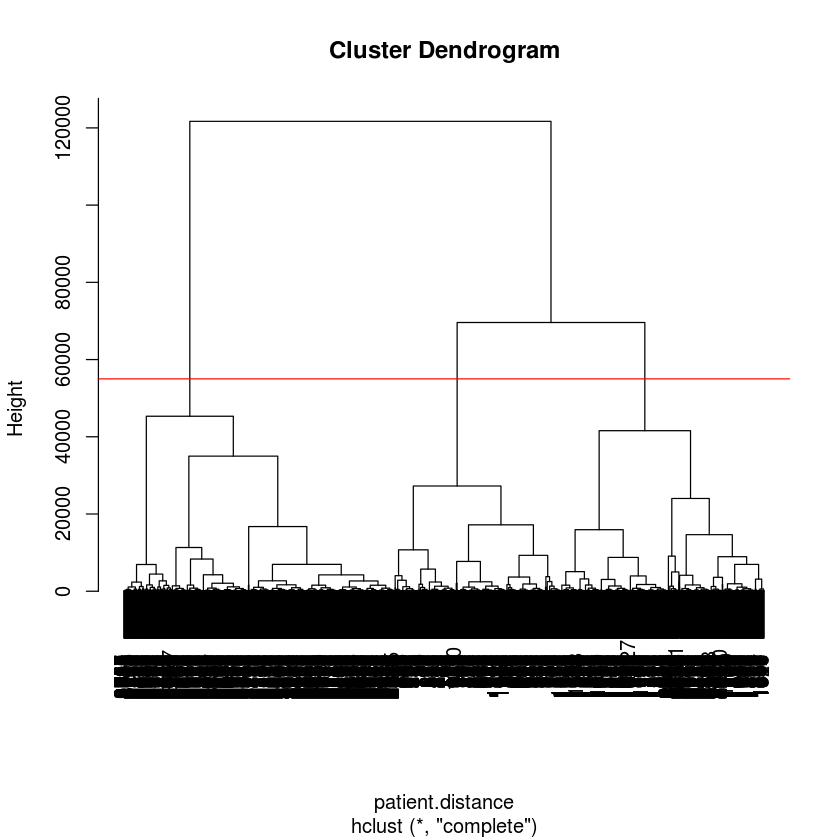

In [18]:
plot(naive.euclidean.clustering)
abline(h=55000, col='red')

Loading required package: ggdendro
Loading required package: repr


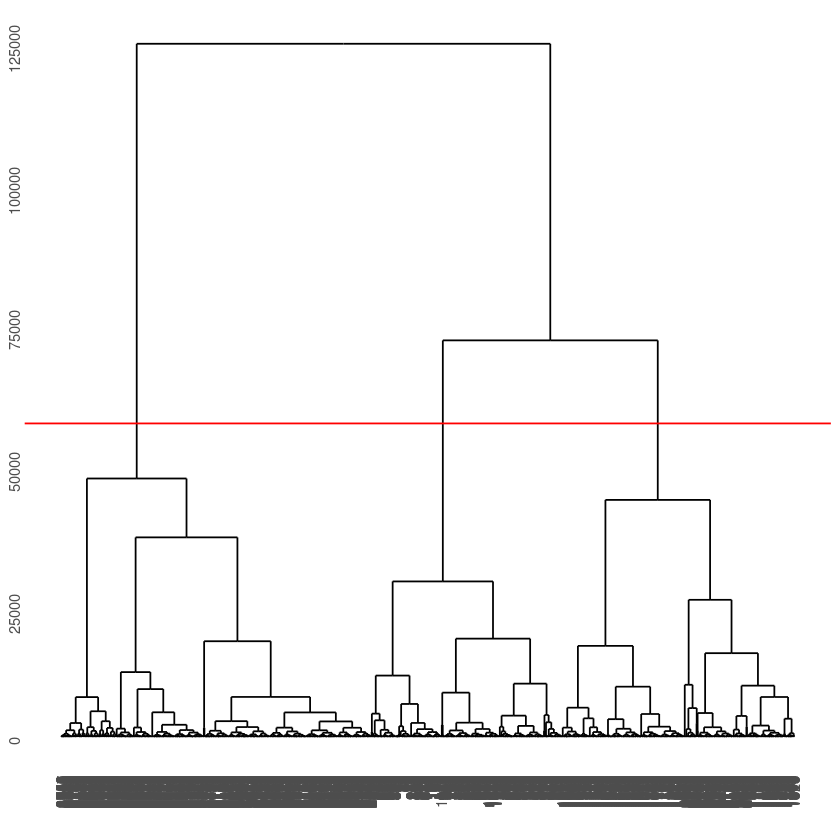

In [19]:
using(ggplot2, ggdendro, repr)
ggdendrogram(naive.euclidean.clustering) +
    geom_hline(yintercept=55000, col='red')

Another way to do this is:
```r
using(ggplot2, ggdendro, repr)
ggdendrogram(naive.euclidean.clustering)
```
But this really takes a long time to render.

We see three clear groups lets go with those and investigate.

In [20]:
using(modelr)
patient.data %>% 
    mutate( group = cutree(naive.euclidean.clustering, 3) ) %>%
    group_by(group) %>%
    summarise( N = n()
             , Pct.Male   = mean(sex == 'M')
             , Age.mean   = mean(age)
             , Age.sd     = sd  (age)
             , DOB.min    = min (dob)
             , DOB.mean   = mean(dob)
             , DOB.max    = max (dob)
             , Death.min  = min (dob)
             , Death.mean = mean(dob)
             , Death.max  = max (dob)
             )
patient.data %>% 
    mutate( group = cutree(naive.euclidean.clustering, 3) ) %>%
    group_by(group) %>%
    summarise( 'Mean Shortest Stay'   = mean(shortest_stay, na.rm=TRUE)
             , 'Mean Longest Stay'    = mean(longest_stay , na.rm=TRUE)
             , 'Mean Num admissions'  = mean(N.admissions , na.rm=TRUE)
             , '% Expire in Hospital' = mean(hospital_expire_flg == 'Y')
             )

Loading required package: modelr


group,N,Pct.Male,Age.mean,Age.sd,DOB.min,DOB.mean,DOB.max,Death.min,Death.mean,Death.max
1,1042,NA,72.43484,16.10415,2420-10-30,2925-02-05 22:20:29,3493-02-05,2420-10-30,2925-02-05 22:20:29,3493-02-05
2,1265,NA,71.96130,16.40150,2405-06-25,2932-09-25 10:46:34,3498-02-04,2405-06-25,2932-09-25 10:46:34,3498-02-04
3,1693,NA,72.23971,16.29983,2411-09-29,2933-12-01 18:01:54,3474-09-13,2411-09-29,2933-12-01 18:01:54,3474-09-13


group,Mean Shortest Stay,Mean Longest Stay,Mean Num admissions,% Expire in Hospital
1,12.89335,12.89335,1.267123,0.3502879
2,13.26710,13.26710,1.335479,0.3849802
3,12.20510,12.20510,1.256076,0.4731246


In [21]:
patient.data %>% 
    mutate( group = cutree(naive.euclidean.clustering, 3) 
          , N = 1                                           # This wil compute the total. 
          ) %>%
    select(-(sex:shortest_stay)) %>%                        # Drop unneeded columns
    select(subject_id, group, N, everything()) %>%          # reorder columns for convenience
    gather(chapter, count, N:ncol(.), factor_key =TRUE) %>% # reshape data
    group_by(group, chapter) %>%
    summarise( N.with = sum(count>0, na.rm=TRUE) ) %>%      # count the subjects with that icd-9 chapter
    spread(group, N.with) %>%                               # spread to compare side by side
    mutate(chapter = fct_relevel(chapter, 'N') ) %>%        # Some cleanup and readability
    mutate(chapter = fct_recode(chapter, 'Total Subjects' = 'N') ) %>%
    arrange(chapter)

chapter,1,2,3
Total Subjects,1042,1265,1693
Infectious And Parasitic Diseases,361,428,619
Neoplasms,261,351,457
"Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders",726,842,1158
Diseases Of The Blood And Blood-Forming Organs,436,495,654
Mental Disorders,237,286,378
Diseases Of The Nervous System And Sense Organs,226,267,372
Diseases Of The Circulatory System,900,1072,1494
Diseases Of The Respiratory System,641,793,1085
Diseases Of The Digestive System,422,495,672


### Some things that we did wrong:


* We left in `subject_id`

In [22]:
patient.data %>% 
    mutate( group = cutree(naive.euclidean.clustering, 3) ) %>%
    group_by(group) %>%
    summarise( min (subject_id)
             , max (subject_id)
             )

group,min(subject_id),max(subject_id)
1,3,7481
2,7492,18619
3,16565,32763


* We did not normalize the prior to finding distance.

In [23]:
patient.data %>% 
    summarise_if(is.numeric, sd, na.rm=TRUE) %>%
    gather(Variable, SD) %>%
    arrange(desc(SD))

Variable,SD
subject_id,8478.1617295
age,16.2783581
longest_stay,14.6032636
shortest_stay,14.6032636
Diseases Of The Circulatory System,3.4553986
"Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders",2.6893769
Diseases Of The Respiratory System,1.8547178
Diseases Of The Digestive System,1.6517011
Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services,1.5017693
Injury And Poisoning,1.4728852


Since `subject_id` had the most variation it rules the distance measure.  Had we properly removed `subject_id` we would have ended up with age groups with some influence by longest stay.  There are times where we would want to have some variables more influential that others, this is not one of those times.

In [78]:
patient.scaled.data <- patient.data %>%
    mutate( hospital_expire_flg = hospital_expire_flg == 'Y'
          , male  = sex == 'M'
          ) %>%
    select(-subject_id, -sex
          # remember we said that dob & dod are only relevent w/i subect_id
          , -dob, -dod) %>%
    mutate_all(scale, center=TRUE, scale=TRUE)
save(patient.scaled.data, file="../patient.scaled.data.Rdata")
patient.scaled.data %>%
    summarise_if(is.numeric, sd, na.rm=TRUE) %>%
    gather(Variable, SD) %>%
    arrange(desc(SD)) %>% head

Warning message:
“attributes are not identical across measure variables; they will be dropped”

Variable,SD
"Complications Of Pregnancy, Childbirth, And The Puerperium",1
Supplementary Classification Of External Causes Of Injury And Poisoning,1
Infectious And Parasitic Diseases,1
N.admissions,1
Neoplasms,1
Diseases Of The Circulatory System,1


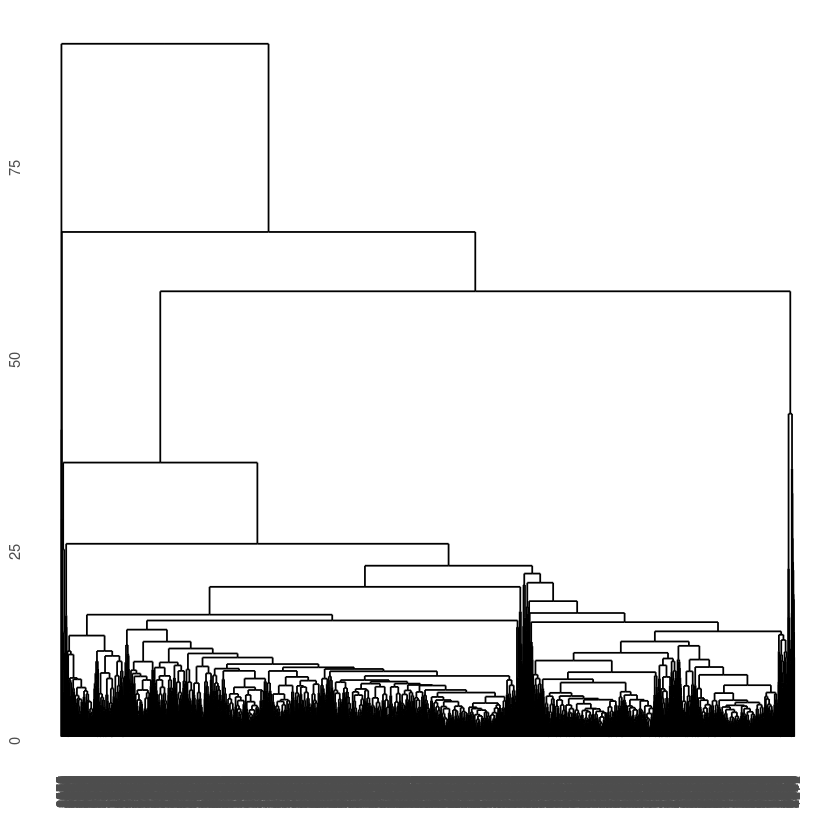

In [25]:
patient.hclust <-  patient.scaled.data %>%
    dist(method='euclidean') %>%
    hclust()
ggdendrogram(patient.hclust)

Very different. **Discuss**

In [26]:
patient.data %>%
    mutate(group = cutree(patient.hclust, 3)) %>%
    count(group)

group,n
1,3996
2,2
3,2


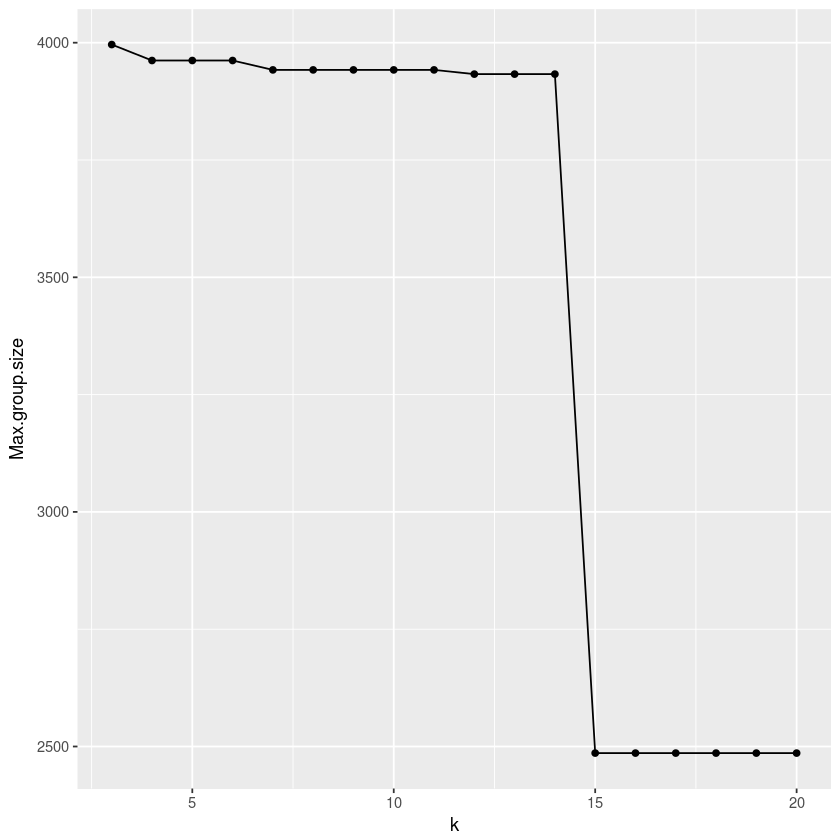

In [27]:
 
max_group_size <- function(k){ patient.data %>%
    mutate(group = cutree(patient.hclust, k)) %>%
    count(group) %>% ungroup %>% 
    summarise("Max group size" = max(n)) %$%
    `Max group size`
}
data_frame( k=3:20 ) %>%
    mutate(Max.group.size = sapply(k, max_group_size) ) %>%
    ggplot(aes(x=k, y=Max.group.size)) %+%
        geom_line() %+% geom_point()


In [28]:
patient.data %>%
    mutate(group = cutree(patient.hclust, 15)) %>%
    count(group)

group,n
1,2486
2,1447
3,2
4,9
5,1
6,18
7,1
8,1
9,9
10,19


In [79]:
abrv_chapter <- . %>% 
fct_recode( 'Infectious and Parasitic'      = 'Infectious And Parasitic Diseases'
          , 'Neoplasms'                     = 'Neoplasms'
          , 'Metabolic and Immunity'        = 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'
          , 'Blood and Blood-Forming Organs'= 'Diseases Of The Blood And Blood-Forming Organs'
          , 'Mental Disorders'              = 'Mental Disorders'
          , 'Nervous and Sense Organs'      = 'Diseases Of The Nervous System And Sense Organs'
          , 'Circulatory System'            = 'Diseases Of The Circulatory System'
          , 'Respiratory System'            = 'Diseases Of The Respiratory System'
          , 'Digestive System'              = 'Diseases Of The Digestive System'
          , 'Genitourinary System'          = 'Diseases Of The Genitourinary System'
          , 'Pregnancy and Childbirth'      = 'Complications Of Pregnancy, Childbirth, And The Puerperium'
          , 'Skin and Subcutaneous Tissue'  = 'Diseases Of The Skin And Subcutaneous Tissue'
          , 'Musculoskeletal and Connective'= 'Diseases Of The Musculoskeletal System And Connective Tissue'
          , 'Congenital Anomalies'          = 'Congenital Anomalies'
          , 'Cond. Orig. Perinatal Period'  = 'Certain Conditions Originating In The Perinatal Period'
          , 'Symptoms and Signs'            = 'Symptoms, Signs, And Ill-Defined Conditions'
          , 'Injury and Poisoning'          = 'Injury And Poisoning'
          , 'Supp - Factors and Contact'    = 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'
          , 'Supp - External Causes'        = 'Supplementary Classification Of External Causes Of Injury And Poisoning'
          )
save(abrv_chapter, file='../abrv_chapter.Rdata')

In [30]:
group.chapter.percents <- patient.data %>% 
    mutate( group = cutree(patient.hclust, 15) 
          , N = 1                                           # This wil compute the total. 
          ) %>%
    select(-(sex:shortest_stay)) %>%                        # Drop unneeded columns
    select(subject_id, group, N, everything()) %>%          # reorder columns for convenience
    gather(chapter, count, N:ncol(.), factor_key =TRUE) %>% # reshape data
    group_by(group, chapter) %>%
    summarise( N.with = sum(count>0, na.rm=TRUE) ) %>%      # count the subjects with that icd-9 chapter
    spread(group, N.with) %>%                               # spread to compare side by side
    mutate(chapter = fct_relevel(chapter, 'N') ) %>%        # Some cleanup and readability
    mutate(chapter = fct_recode(chapter, 'Total' = 'N') ) %>%
    mutate(chapter = abrv_chapter(chapter)) %>% 
    arrange(chapter) %>%
    mutate_if(is.integer, funs(./max(.))) %>%
    mutate_if(is.numeric, format.percent, places=0) 
group.counts <- patient.data %>% 
    mutate( group = cutree(patient.hclust, 15) 
          ) %>%
    count(group) %>%
    mutate(n=format(n), chapter='Count') %>%
    select(chapter, everything()) %>%
    spread(group, n)
bind_rows(group.counts, group.chapter.percents)

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

chapter,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Count,2486,1447,2,9,1,18,1,1,9,19,2,1,2,1,1
Total,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
Infectious and Parasitic,40%,27%,0%,100%,100%,17%,100%,0%,33%,74%,100%,100%,100%,100%,0%
Neoplasms,26%,27%,0%,11%,100%,0%,0%,0%,33%,37%,0%,0%,100%,0%,100%
Metabolic and Immunity,67%,70%,50%,100%,100%,28%,100%,0%,67%,58%,100%,100%,100%,100%,0%
Blood and Blood-Forming Organs,39%,40%,0%,100%,100%,11%,100%,0%,33%,74%,100%,100%,100%,100%,0%
Mental Disorders,25%,18%,0%,67%,100%,0%,100%,100%,33%,16%,100%,100%,50%,100%,0%
Nervous and Sense Organs,23%,19%,50%,100%,100%,6%,100%,0%,33%,42%,50%,100%,0%,100%,100%
Circulatory System,85%,90%,50%,100%,100%,44%,100%,100%,67%,84%,100%,100%,100%,100%,0%
Respiratory System,66%,58%,50%,100%,100%,6%,100%,0%,44%,84%,100%,100%,100%,100%,0%


### What can we learn here?
**Discuss**

In [31]:
# Pause for dicussions















Some things that I note:
* two large groups 1 & 2.
    * marked differences.
* Groups  6 and 10 bear further investigation.
* the other groups we should look at if they are 'outliers' or 'anomolies'.

## K Means

K means is for if you know the number of groups you want `k`.  K means finds centers for the `k` clusters that minimizes the sum of squares (ie. euclidean distance) between observations and their closest cluster center (their predicted cluster).

> **Note:**
> Since K means uses euclidian distance it is sensitive to scaling differences in variables.

In [32]:
## reuse the patient.scaled.data
patient.kmeans <- patient.scaled.data %>% 
    na.omit %>%
    kmeans( centers = 3
          , algorithm = "Hartigan-Wong"
          )


In [33]:
patient.data %>% na.omit %>%
    mutate( group = fitted(patient.kmeans, 'classes')
          ) %>%
    count(group)

group,n
1,3123
2,35
3,780


In [34]:
fitted(patient.kmeans) %>% tidy %>% distinct

#%>% distinct

ERROR: Error in function_list[[i]](value): could not find function "tidy"


## Self Organizing Maps

In [35]:
using(kohonen)

Loading required package: kohonen


In [70]:
patient.som <- 
patient.scaled.data %>%
    na.omit %>% 
    as.matrix %>%
    som( grid = somgrid(xdim=10, ydim=10, topo="rect")
       , rlen = 500     #Number of iterations
       ) 

In [71]:
summary(patient.som)

SOM of size 10x10 with a rectangular topology and a bubble neighbourhood function.
Training data included of 3938 objects
The number of layers is 1
Mean distance to the closest unit in the map: 8.538141


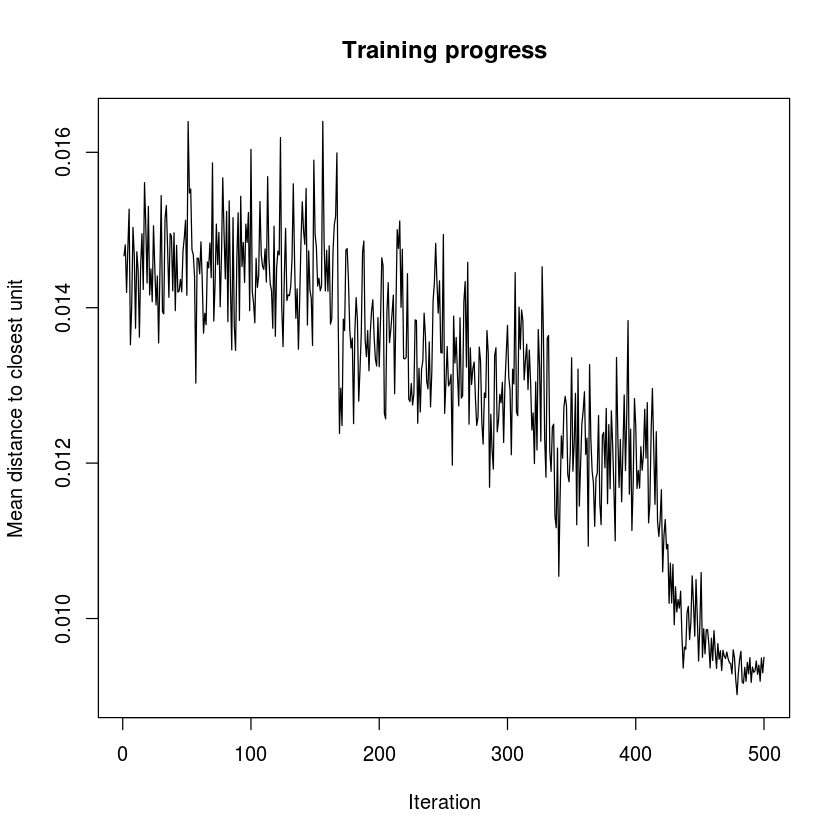

In [72]:
plot(patient.som, type="changes")

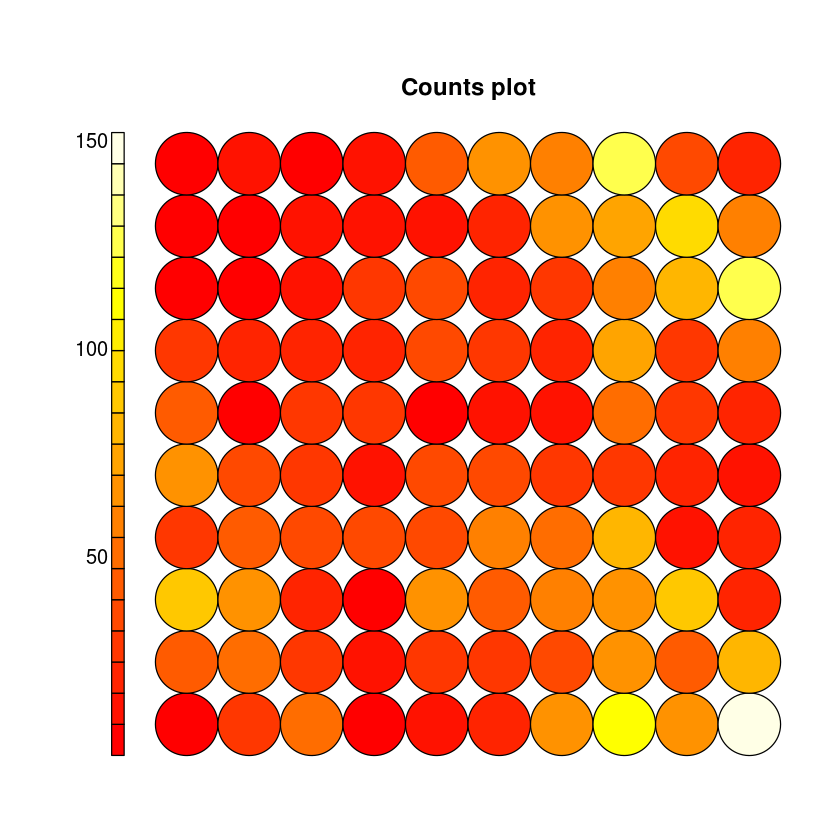

In [73]:
plot(patient.som, type="counts")

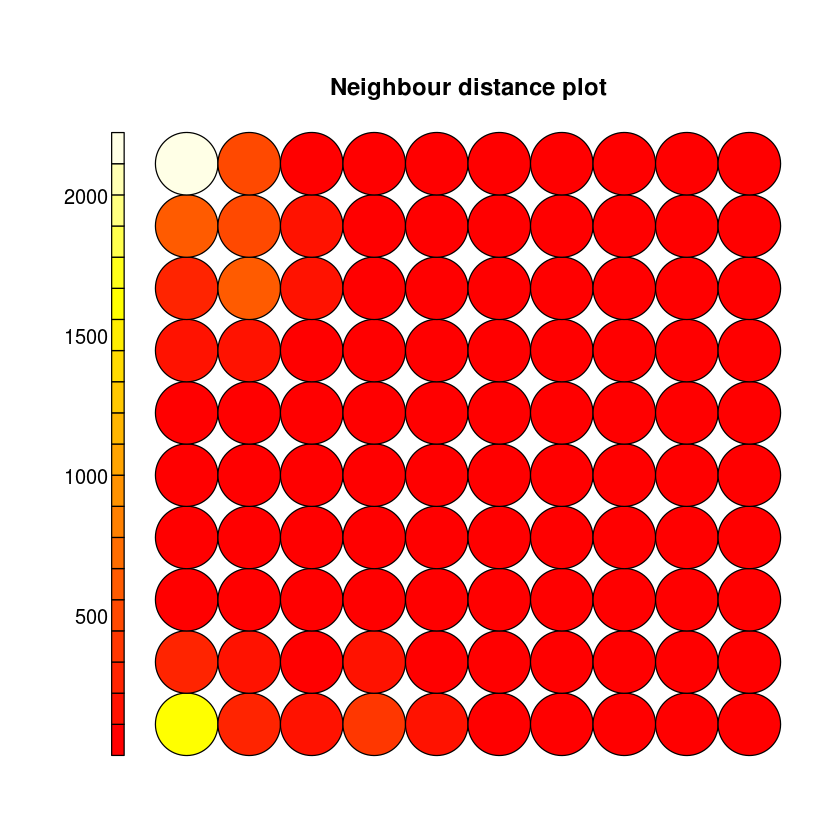

In [74]:
plot(patient.som, type="dist.neighbours")

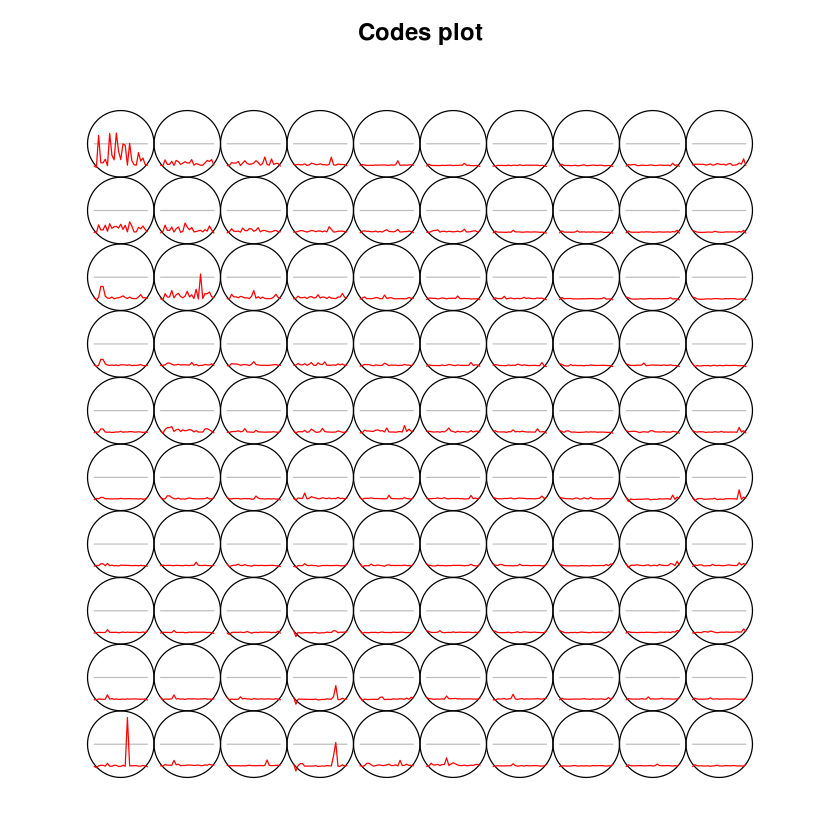

In [75]:
plot(patient.som, type='codes')

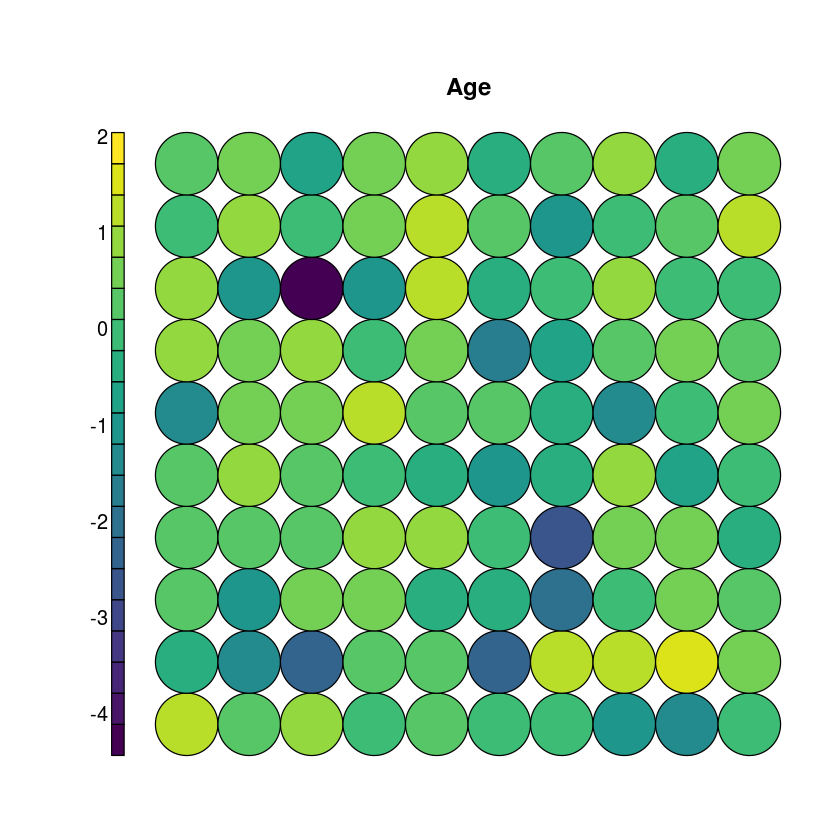

In [76]:
using(viridis)
plot( patient.som, type="property"
    , property = patient.scaled.data$age
    , main = "Age", palette.name=viridis_pal()
    )

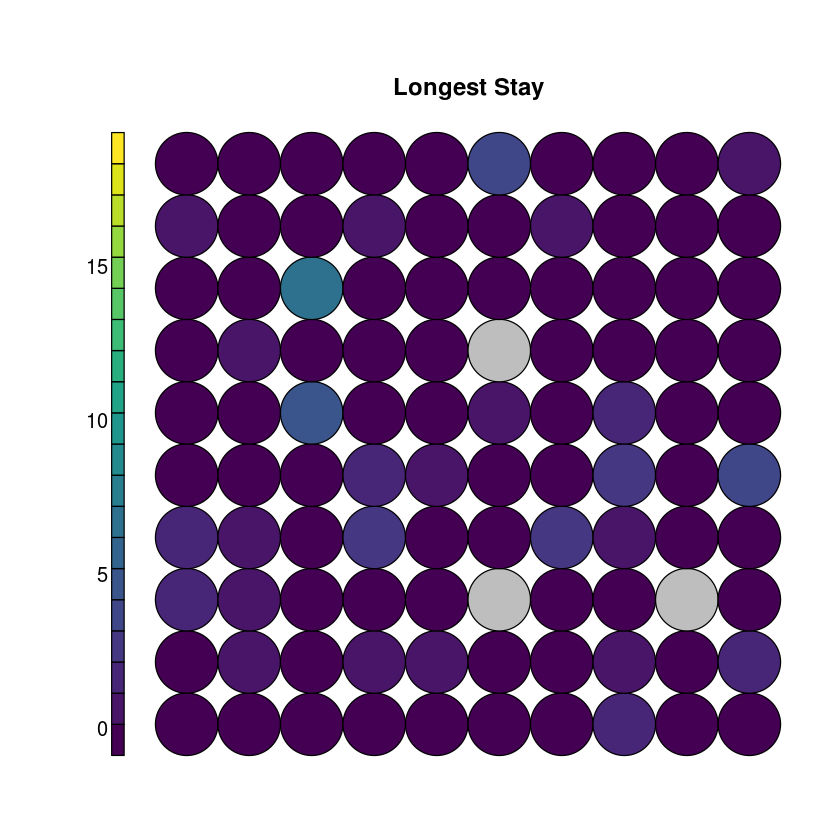

In [77]:
plot( patient.som, type="property"
    , property = patient.scaled.data$longest_stay
    , main = "Longest Stay", palette.name=viridis_pal()
    )